# Import Library

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import pylab as pl
from PIL import Image
from ultralytics import YOLO
import os
import yaml


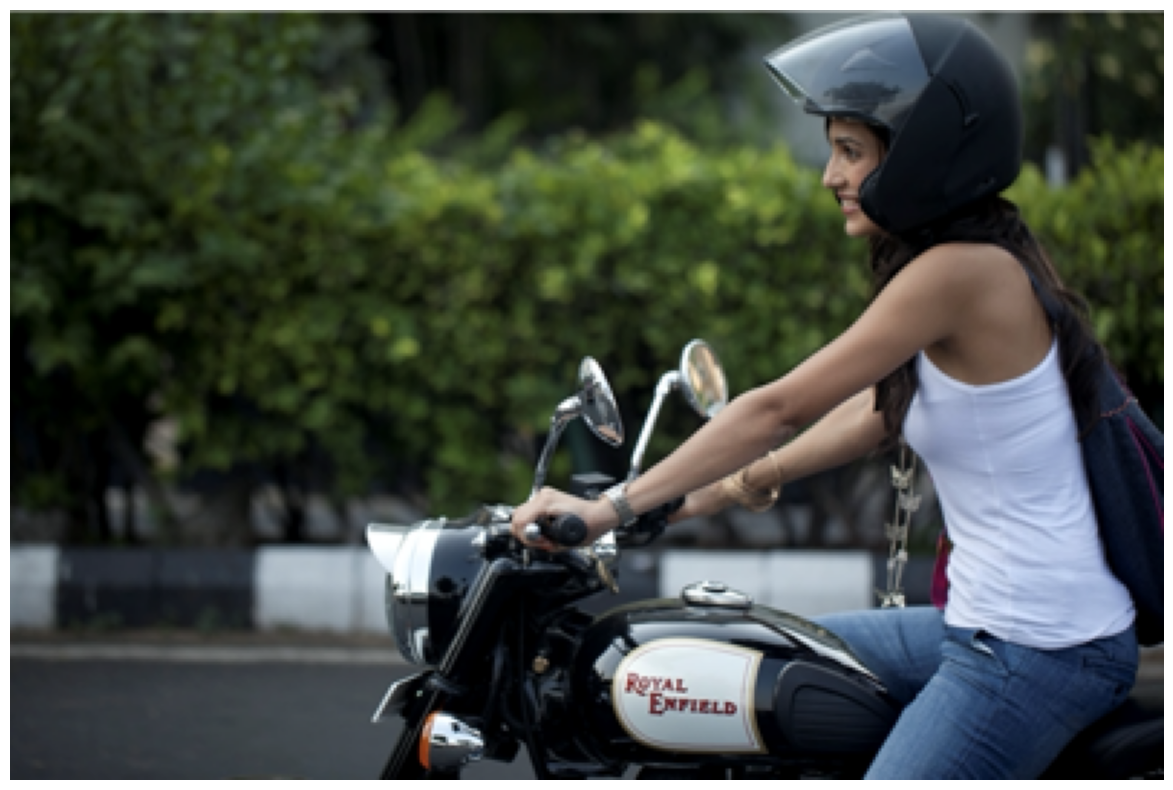

In [ ]:
img0 = r"C:\Users\Sujit Chaudhary\Downloads\sujit\Helmet Detection\images\BikesHelmets90.png"
_ = plt.figure(figsize = (20,10))
_ = plt.axis('off')
_ = plt.imshow(mpimg.imread(img0))

# Converting XML to YOLO format

In [ ]:
import xml.etree.ElementTree as ET
import glob
import os
import json


def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]


def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]


classes = []
input_dir = r"C:\Users\Sujit Chaudhary\Downloads\sujit\Helmet Detection\annotations"
output_dir = r"C:\Users\Sujit Chaudhary\Downloads\sujit\Helmet Detection\labels"
image_dir = r"C:\Users\Sujit Chaudhary\Downloads\sujit\Helmet Detection\images"

# create the labels folder (output directory)
if not os.path.isdir(output_dir):
    os.mkdir(output_dir)

# identify all the xml files in the annotations folder (input directory)
files = glob.glob(os.path.join(input_dir, '*.xml'))
# loop through each
for fil in files:
    basename = os.path.basename(fil)
    filename = os.path.splitext(basename)[0]
    # check if the label contains the corresponding image file
    if not os.path.exists(os.path.join(image_dir, f"{filename}.png")):
        print(f"{filename} image does not exist!")
        continue

    result = []

    # parse the content of the xml file
    tree = ET.parse(fil)
    root = tree.getroot()
    width = int(root.find("size").find("width").text)
    height = int(root.find("size").find("height").text)

    for obj in root.findall('object'):
        label = obj.find("name").text
        # check for new classes and append to list
        if label not in classes:
            classes.append(label)
        index = classes.index(label)
        pil_bbox = [int(x.text) for x in obj.find("bndbox")]
        yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
        # convert data to string
        bbox_string = " ".join([str(x) for x in yolo_bbox])
        result.append(f"{index} {bbox_string}")

    if result:
        # generate a YOLO format text file for each xml file
        with open(os.path.join(output_dir, f"{filename}.txt"), "w", encoding="utf-8") as f:
            f.write("\n".join(result))

# generate the classes file as reference
with open('classes.txt', 'w', encoding='utf8') as f:
    f.write(json.dumps(classes))

print("XML to YOLO Format Done!!")


XML to YOLO Format Done!!


# Drawing a bounding box

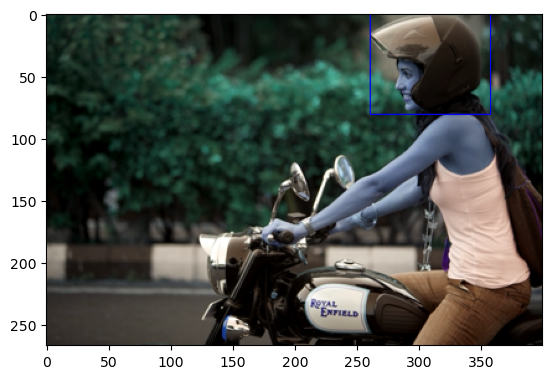

In [ ]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread(r"C:\Users\Sujit Chaudhary\Downloads\sujit\Helmet Detection\images\BikesHelmets90.png")
dh, dw, _ = img.shape

fl = open(r"C:\Users\Sujit Chaudhary\Downloads\sujit\Helmet Detection\labels\BikesHelmets90.txt", 'r')
data = fl.readlines()
fl.close()

for dt in data:

    # Split string to float
    _, x, y, w, h = map(float, dt.split(' '))

    # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
    # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)

    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    cv2.rectangle(img, (l, t), (r, b), (0, 0, 255), 1)

plt.imshow(img)
plt.show()


# Train Test Split
## There shouldn't be labels, train, val, test folder in working directory

In [ ]:
# Create a dataset.yaml File

In [ ]:

# Define the paths and configuration
dataset_config = {
    "train": r"C:\Users\Sujit Chaudhary\Downloads\sujit\train\images",  # Path to the training images
    "val": r"C:\Users\Sujit Chaudhary\Downloads\sujit\valid\images",    # Path to the validation images
    "test": r"C:\Users\Sujit Chaudhary\Downloads\sujit\test\images",    # Path to the test images
    "nc": 2,               # Number of classes (2 for helmet and Without Helmet)
    "names": ['helmet', "Without Helmet"],  # Class names
    "labels": r"C:\Users\Sujit Chaudhary\Downloads\sujit\train\labels",      # Path to the labels for the training images
    "val_labels": r"C:\Users\Sujit Chaudhary\Downloads\sujit\valid\labels",  # Path to the labels for the validation images
    "test_labels": r"C:\Users\Sujit Chaudhary\Downloads\sujit\test\labels"   # Path to the labels for the test images
}

# Specify the path to save the dataset.yaml configuration
yaml_file_path = "dataset.yaml"

# Save the dataset.yaml configuration to the specified file path
with open(yaml_file_path, "w") as yaml_file:
    yaml.dump(dataset_config, yaml_file, default_flow_style=False)

print(f"dataset.yaml created successfully at path: {os.path.abspath(yaml_file_path)}")

## Training YOLO

model = YOLO('yolov8m.pt')

# Train the model
model.train(data=r"C:\Users\Admin\Downloads\sujit\dataset.yaml", epochs=2)


dataset.yaml created successfully at path: C:\Users\Sujit Chaudhary\Downloads\sujit\dataset.yaml


# Helmet detection


0: 640x512 1 helmet, 4 Without Helmets, 515.6ms
Speed: 8.0ms preprocess, 515.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


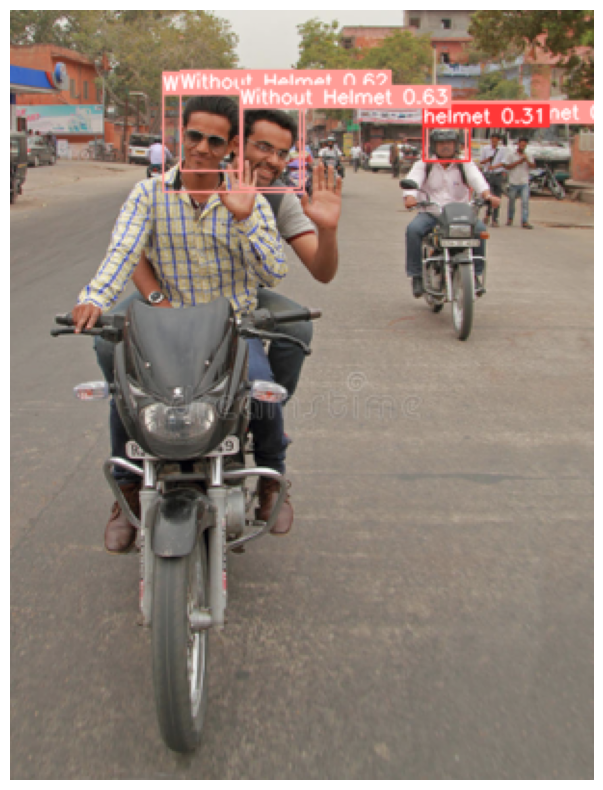

In [ ]:
model = YOLO(r"C:\Users\Sujit Chaudhary\Downloads\sujit\runs_v0\detect\train2\weights\best.pt")

from PIL import Image
import cv2
img = cv2.imread(r"C:\Users\Sujit Chaudhary\Downloads\sujit\train\images\BikesHelmets154.png")   ###########
prediction = model.predict(img)[0]
# print(prediction)

prediction = prediction.plot(line_width=1)
prediction = prediction[:, :, ::-1]
prediction = Image.fromarray(prediction)
prediction.save(r"output/output_image.png")

img0 = r"output/output_image.png"
_ = plt.figure(figsize = (20,10))
_ = plt.axis('off')
_ = plt.imshow(mpimg.imread(img0))


0: 448x640 2 helmets, 437.4ms
Speed: 5.7ms preprocess, 437.4ms inference, 0.0ms postprocess per image at shape (1, 3, 448, 640)


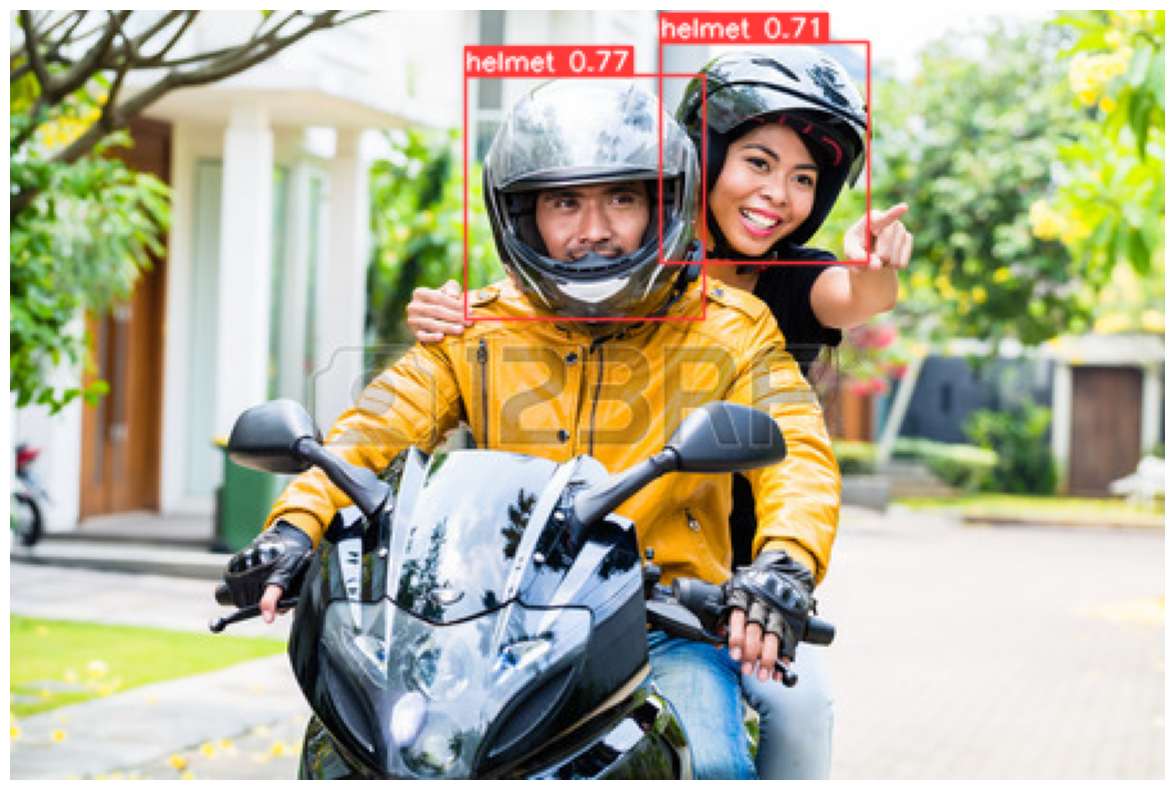

In [ ]:
model = YOLO(r"C:\Users\Sujit Chaudhary\Downloads\sujit\runs_v0\detect\train2\weights\best.pt")

from PIL import Image
import cv2
img = cv2.imread(r"C:\Users\Sujit Chaudhary\Downloads\sujit\Helmet Detection\images\BikesHelmets347.png")
prediction = model.predict(img)[0]
# print(prediction)

prediction = prediction.plot(line_width=1)
prediction = prediction[:, :, ::-1]
prediction = Image.fromarray(prediction)
prediction.save(r"output/output_image.png")

img0 = r"output/output_image.png"
_ = plt.figure(figsize = (20,10))
_ = plt.axis('off')
_ = plt.imshow(mpimg.imread(img0))


0: 640x512 1 helmet, 4 Without Helmets, 505.2ms
Speed: 2.1ms preprocess, 505.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 512)


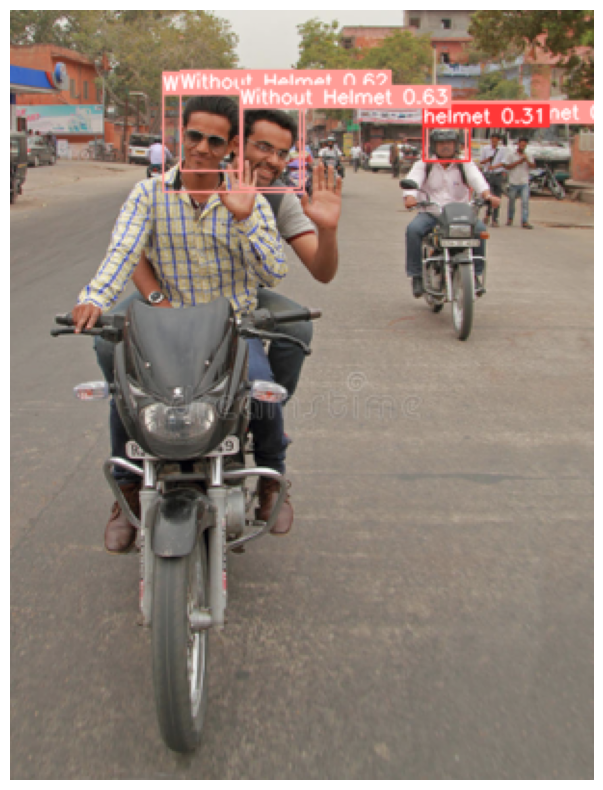

In [ ]:
model = YOLO(r"C:\Users\Sujit Chaudhary\Downloads\sujit\runs_v0\detect\train2\weights\best.pt")

from PIL import Image
import cv2
img = cv2.imread(r"C:\Users\Sujit Chaudhary\Downloads\sujit\Helmet Detection\images\BikesHelmets154.png") ###########
prediction = model.predict(img)[0]
# print(prediction)

prediction = prediction.plot(line_width=1)
prediction = prediction[:, :, ::-1]
prediction = Image.fromarray(prediction)
prediction.save(r"output/output_image.png")

img0 = r"output/output_image.png"
_ = plt.figure(figsize = (20,10))
_ = plt.axis('off')
_ = plt.imshow(mpimg.imread(img0))